In [8]:
import numpy as np
import torch
#import gradio as gr
from huggingface_hub import from_pretrained_keras
import requests
from PIL import Image
import matplotlib.cm as cm
# import matplotlib.pyplot as plt
import os
import PIL

from torchvision import datasets, transforms

from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import models_vit
import utils
import torch.nn.functional as F

In [9]:
classes = ['Alicante', 'Alveralhao', 'Arinto', 'Bastardo', 'Boal',
       'Cabernet Franc', 'Cabernet Sauvignon', 'Carignon Noir', 'Cercial',
       'Chardonnay', 'Codega', 'Codega do Larinho', 'Cornifesto',
       'Donzelinho Branco', 'Donzelinho Tinto', 'Esgana Cao',
       'Fernao Pires', 'Folgasao', 'Gamay', 'Gouveio', 'Malvasia Corada',
       'Malvasia Fina', 'Malvasia Preta', 'Malvasia Rei', 'Merlot',
       'Moscatel Galego', 'Moscatel Galego Roxo', 'Mourisco Tinto',
       'Pinot Blanc', 'Rabigato', 'Rufete', 'Samarrinho',
       'Sauvignon Blanc', 'Sousao', 'Tinta Amarela', 'Tinta Barroca',
       'Tinta Femea', 'Tinta Francisca', 'Tinta Roriz', 'Tinto Cao',
       'Touriga Francesa', 'Touriga Nacional', 'Viosinho']

In [10]:
target_size_dimension = 224
n_classes = len(classes)
model = 'vit_base_patch16'
weights = '/media/gabriel/BA1041B4104178811/Users/gabrielc/Projects/mae/output_only_imagenet/ft/base/checkpoint.pth'
#/media/gabriel/BA1041B4104178811/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth

def get_last_selfattention(model, x):
    x = model.patch_embed(x)
    x = model._pos_embed(x)
    x = model.patch_drop(x)
    x = model.norm_pre(x)
    for i, blk in enumerate(model.blocks):
        if i < len(model.blocks) - 1:
            x = blk(x)
        else:
            x = blk.norm1(x)
            B, N, C = x.shape
            qkv = blk.attn.qkv(x).reshape(B, N, 3, blk.attn.num_heads, blk.attn.head_dim).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)
            q, k = blk.attn.q_norm(q), blk.attn.k_norm(k)

            if blk.attn.fused_attn:
                x = F.scaled_dot_product_attention(
                    q, k, v,
                    dropout_p=blk.attn.attn_drop.p,
                )
            else:
                q = q * blk.attn.scale
                attn = q @ k.transpose(-2, -1)
                attn = attn.softmax(dim=-1)

            return attn

In [11]:
#compose transform
t = []
t.append(
    transforms.Resize((target_size_dimension, target_size_dimension), interpolation=PIL.Image.BICUBIC),  # to maintain same ratio w.r.t. 224 images
)
#t.append(transforms.CenterCrop(target_size_dimension))

t.append(transforms.ToTensor())
t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
t = transforms.Compose(t)

model = models_vit.__dict__[model](
    num_classes=n_classes,
    global_pool=True,
    drop_path_rate = 0.1
)

print(weights)
state = torch.load(weights, map_location='cpu')
print(state.keys())
msg = model.load_state_dict(state['model'], strict=False)
print(msg)
model.to('cpu')
model.to('cuda')
model.eval()


/media/gabriel/BA1041B4104178811/Users/gabrielc/Projects/mae/output_epochs/ft/base/2000/checkpoint.pth
dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
<All keys matched successfully>


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1-11): 11 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (a

In [12]:

dataset = '/media/gabriel/7739-DDF5/Gabriel/Datasets/2024/processed/compilado/'
ds = datasets.ImageFolder(dataset, transform=t)
sampler = torch.utils.data.SequentialSampler(ds)
dl = torch.utils.data.DataLoader(ds, sampler=sampler, batch_size=48, num_workers=1, pin_memory=True)

              precision    recall  f1-score   support

          AC     0.9535    0.4100    0.5734       100
          AV     0.6564    0.6524    0.6544       164
          AT     0.3672    0.2938    0.3264       160
          BT     0.2909    0.5333    0.3765        60
          BA     0.5724    0.6241    0.5971       133
          CF     0.6667    0.1667    0.2667        60
          CS     0.8333    0.6667    0.7407        60
          CN     0.5455    0.2951    0.3830        61
          CC     0.4316    0.5616    0.4881       146
          CD     0.2895    0.5500    0.3793        60
          CG     0.3317    0.4823    0.3931       141
          CR     0.3108    0.6509    0.4207       106
          CT     0.6333    0.3167    0.4222        60
          DB     0.2475    0.3063    0.2737       160
          DT     0.6765    0.4182    0.5169        55
          EC     0.3895    0.3083    0.3442       120
          FP     0.6000    0.0283    0.0541       106
          FG     0.4038    

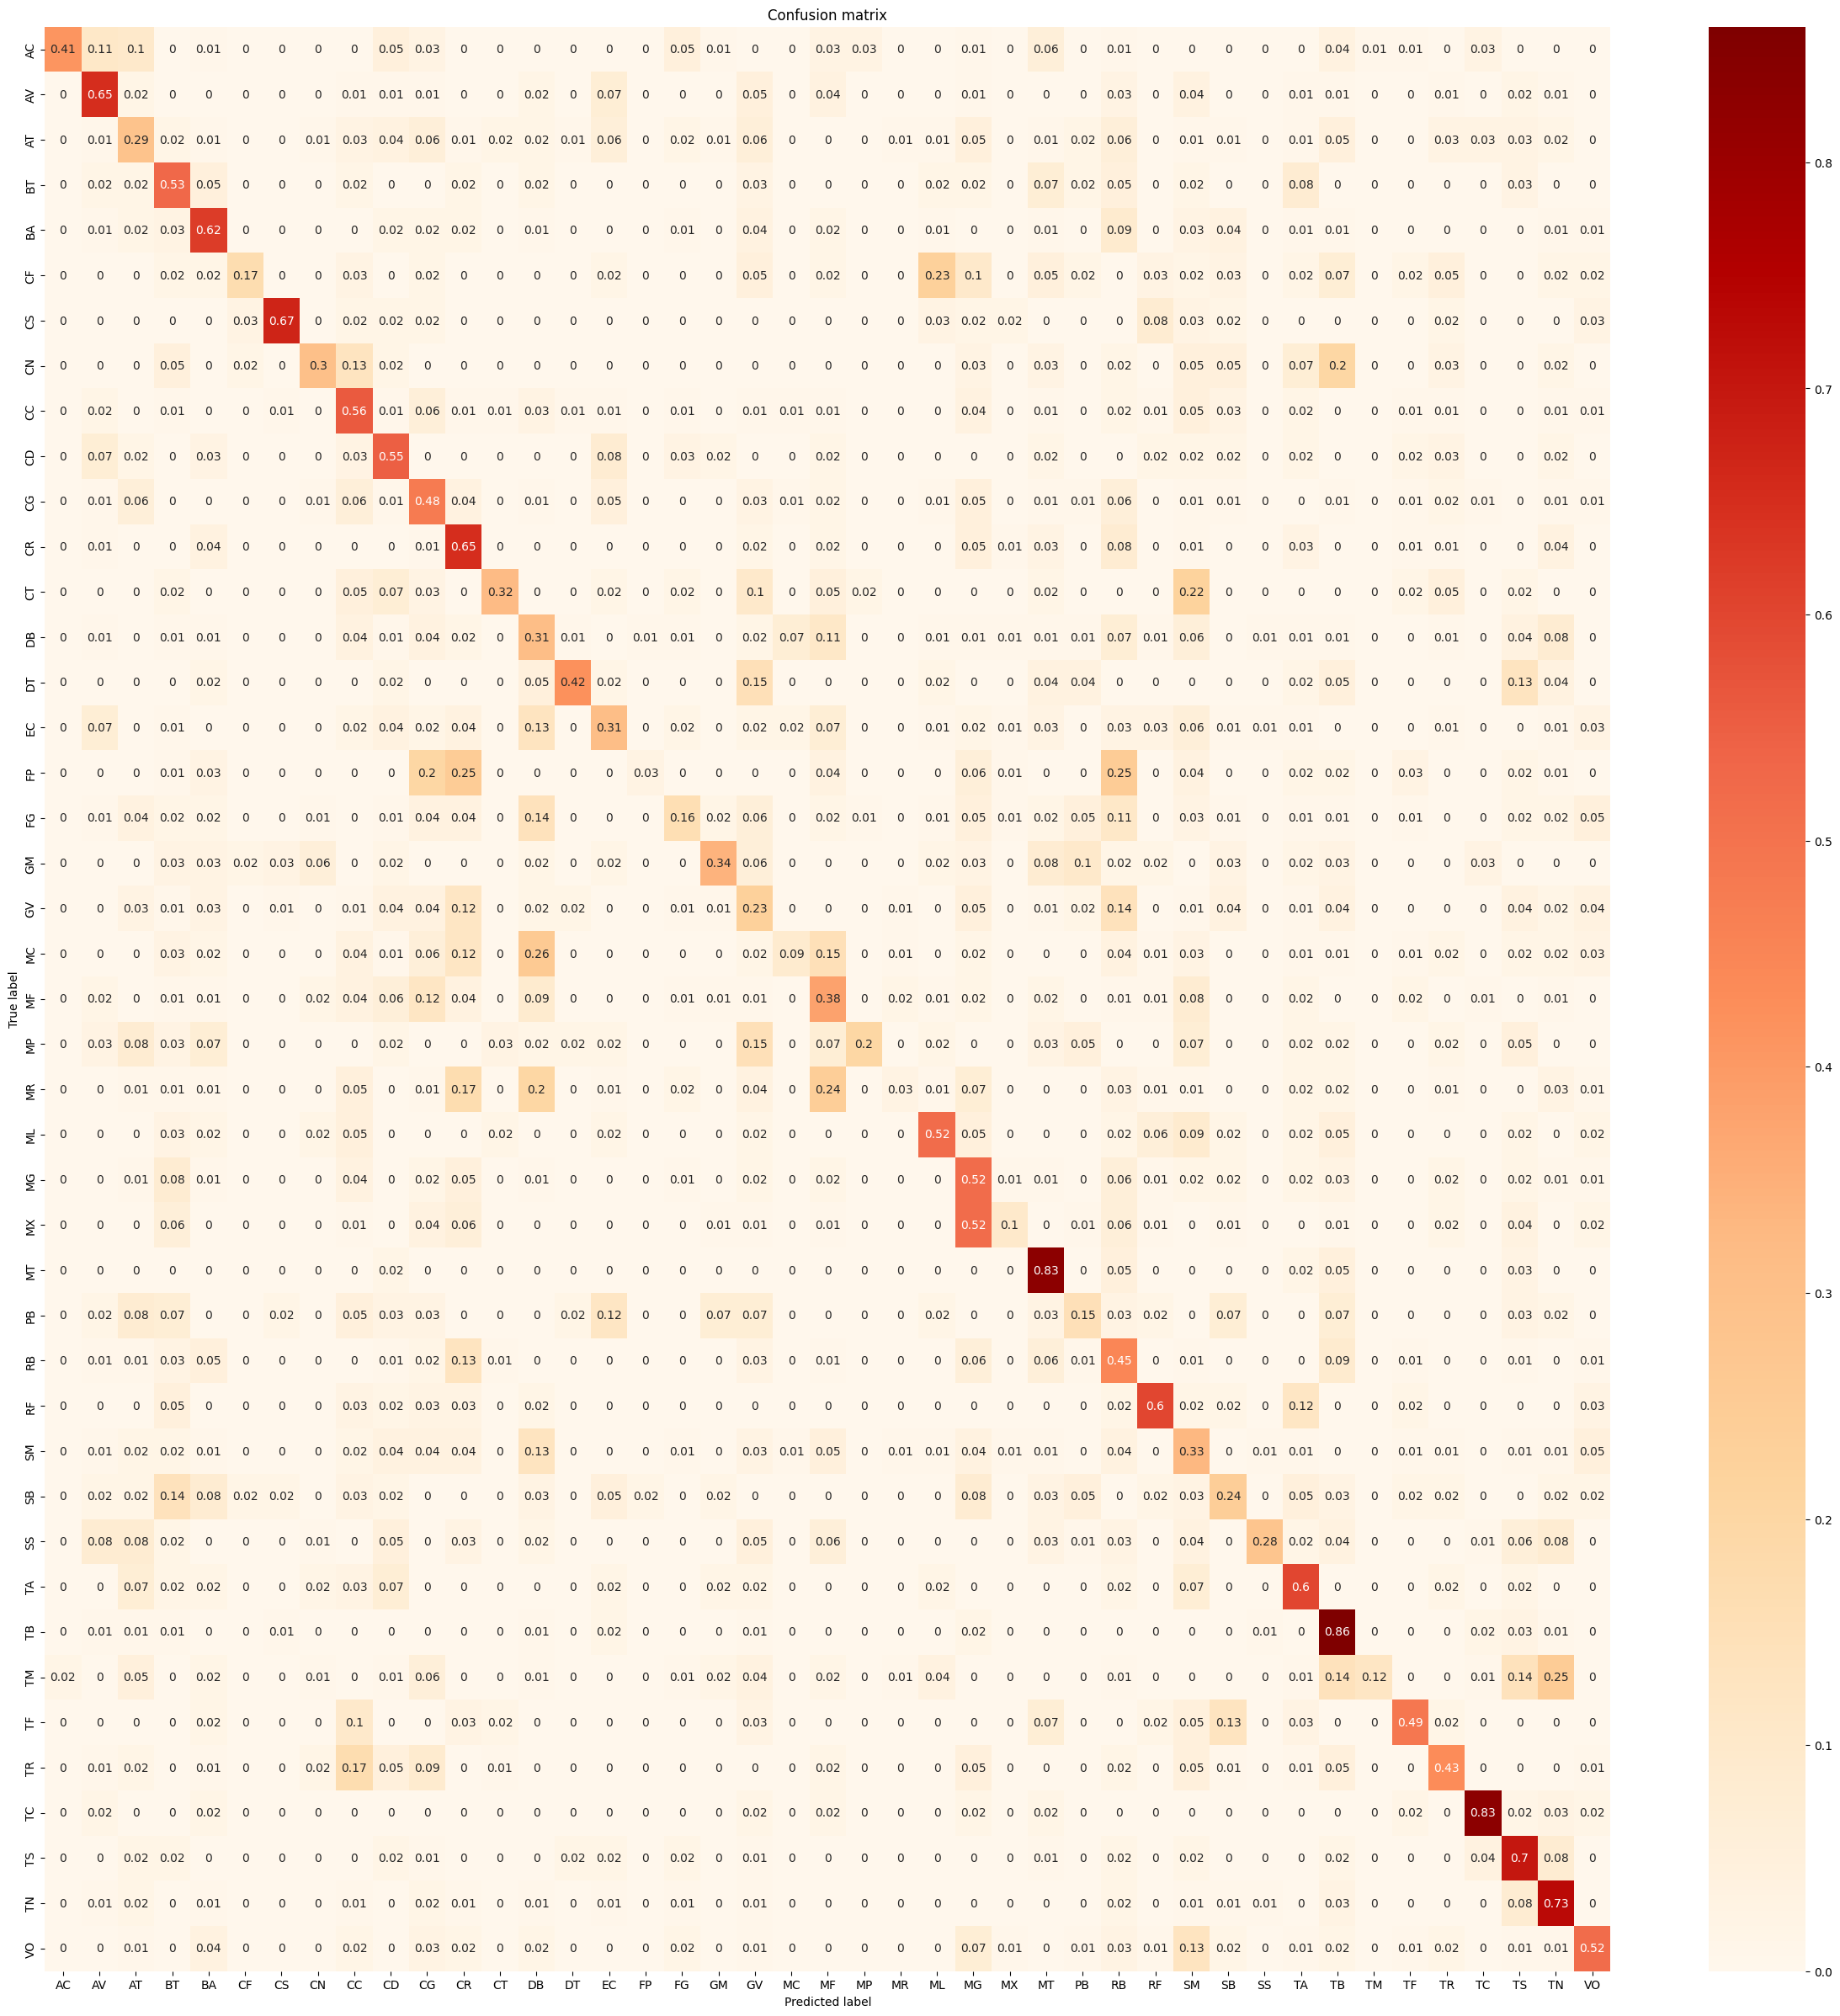

In [13]:
classes_alias = {'tinto cao': 'TC', 'tinta francisca': 'TF', 'alicante': 'AC', 'alveralhao': 'AV', 'arinto': 'AT', 'bastardo': 'BT', 'boal': 'BA', 'cabernet franc': 'CF', 'cabernet sauvignon': 'CS', 'carignon noir': 'CN', 'cercial': 'CC', 'chardonnay': 'CD', 'codega': 'CG', 'codega do larinho': 'CR', 'cornifesto': 'CT', 'donzelinho': 'DZ', 'donzelinho branco': 'DB', 'donzelinho tinto': 'DT', 'esgana cao': 'EC', 'fernao pires': 'FP', 'folgasao': 'FG', 'gamay': 'GM', 'gouveio': 'GV', 'malvasia corada': 'MC', 'malvasia fina': 'MF', 'malvasia preta': 'MP', 'malvasia rei': 'MR', 'merlot': 'ML', 'moscatel galego': 'MG', 'moscatel galego roxo': 'MX', 'mourisco tinto': 'MT', 'pinot blanc': 'PB', 'rabigato': 'RB', 'rufete': 'RF', 'samarrinho': 'SM', 'sauvignon blanc': 'SB', 'sousao': 'SS', 'tinta amarela': 'TA', 'tinta barroca': 'TB', 'tinta femea': 'TM', 'tinta roriz': 'TR', 'touriga francesa': 'TS', 'touriga nacional': 'TN', 'viosinho': 'VO'}
report = utils.confusion_matrix(dl, model, class_labels=[classes_alias[c.lower()] for c in classes],mode='pytorch', sns=True, normalize=True)

In [14]:
import json

json.dumps(classes_alias)

'{"tinto cao": "TC", "tinta francisca": "TF", "alicante": "AC", "alveralhao": "AV", "arinto": "AT", "bastardo": "BT", "boal": "BA", "cabernet franc": "CF", "cabernet sauvignon": "CS", "carignon noir": "CN", "cercial": "CC", "chardonnay": "CD", "codega": "CG", "codega do larinho": "CR", "cornifesto": "CT", "donzelinho": "DZ", "donzelinho branco": "DB", "donzelinho tinto": "DT", "esgana cao": "EC", "fernao pires": "FP", "folgasao": "FG", "gamay": "GM", "gouveio": "GV", "malvasia corada": "MC", "malvasia fina": "MF", "malvasia preta": "MP", "malvasia rei": "MR", "merlot": "ML", "moscatel galego": "MG", "moscatel galego roxo": "MX", "mourisco tinto": "MT", "pinot blanc": "PB", "rabigato": "RB", "rufete": "RF", "samarrinho": "SM", "sauvignon blanc": "SB", "sousao": "SS", "tinta amarela": "TA", "tinta barroca": "TB", "tinta femea": "TM", "tinta roriz": "TR", "touriga francesa": "TS", "touriga nacional": "TN", "viosinho": "VO"}'